In [6]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.nn import functional
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from torchvision import transforms
from torchvision.datasets import ImageFolder

from train_veg import ModelManager, Mode, DIR_ROOT_SAVE
from utils_veg import plot_img_and_top, get_loader

DATA_PATH = os.path.join(os.path.abspath('./dataset'), 'veg')
DATA_PATH_TRAIN = os.path.join(DATA_PATH, 'train')
DATA_PATH_VAL = os.path.join(DATA_PATH, 'validation')
DATA_PATH_TEST = os.path.join(DATA_PATH, 'test')
NOTEBOOK_NAME = 'veg'
PATH_MEASURES = os.path.join(DIR_ROOT_SAVE, NOTEBOOK_NAME, 'measure.pt')

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_train = ImageFolder(DATA_PATH_TRAIN, transform=transform_train)
dataset_val = ImageFolder(DATA_PATH_VAL, transform=transform_test)
dataset_test = ImageFolder(DATA_PATH_TEST, transform=transform_test)
dataset_train_ordered = ImageFolder(DATA_PATH_TRAIN, transform=transform_test)
dataset_train_raw = ImageFolder(DATA_PATH_TRAIN)
dataset_test_raw = ImageFolder(DATA_PATH_TEST)

NUM_TRAIN = len(dataset_train)
TRAIN_IDX = np.arange(NUM_TRAIN)
NUM_VAL = len(dataset_val)
NUM_TEST = len(dataset_test)
CLASSES = dataset_train.classes
NUM_CLASSES = len(CLASSES)
PRUNE_EPOCHS = 10
ENSEMBLE_EPOCHS = 10
ENSEMBLE_SIZE = 10
BATCH_SIZE = 25
EPOCHS = 25

loader_train = get_loader(dataset_train, TRAIN_IDX, batch_size=BATCH_SIZE, shuffle=True)
loader_train_ordered = get_loader(dataset_train_ordered, TRAIN_IDX, batch_size=BATCH_SIZE, shuffle=False)
loader_val = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,
                        prefetch_factor=4, pin_memory=True, persistent_workers=True)
loader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,
                         prefetch_factor=4, pin_memory=True, persistent_workers=True)

# Demonstration of the augmentation: first line is the original image and second line is after the  augmentation

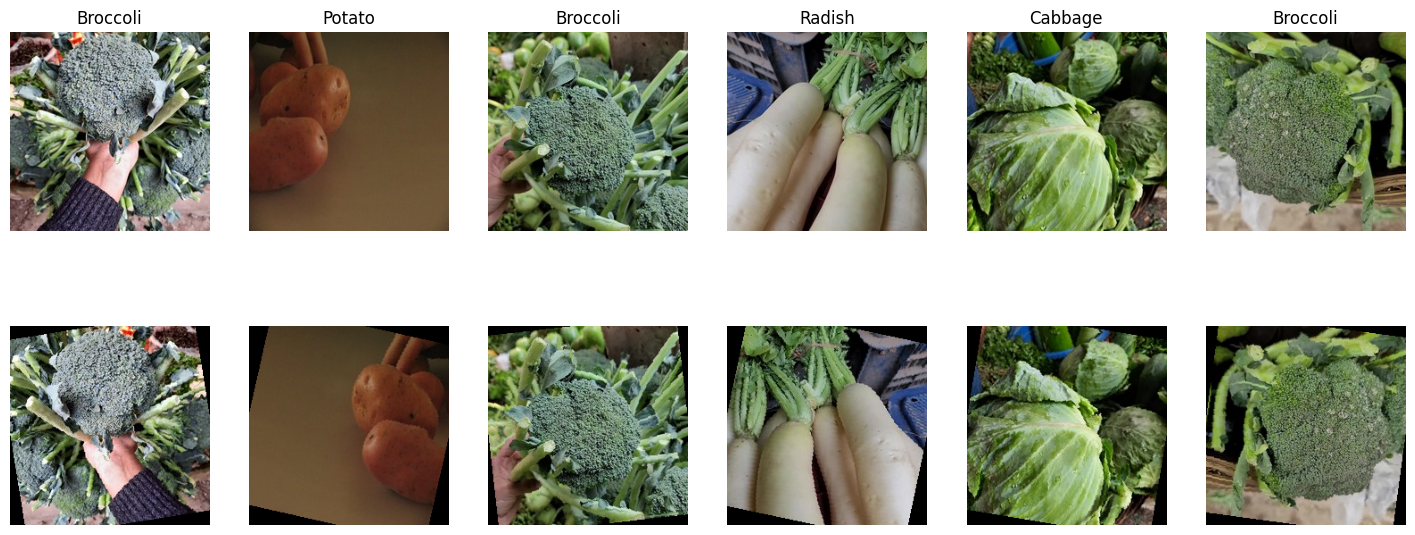

In [2]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
])

i = random.randint(0, NUM_TEST)
fig, axes = plt.subplots(2, 6, figsize=(18, 7))

for j in range(6):
    i = random.randint(0, NUM_TEST)
    axes[0][j].axis('off')
    axes[1][j].axis('off')
    axes[0][j].imshow(dataset_test_raw[i][0])
    axes[0][j].set_title(dataset_test_raw.classes[dataset_test_raw[i][1]])
    axes[1][j].imshow(trans(dataset_test_raw[i][0]))

plt.show()

# check simple model's acc on the data

In [2]:
model_manager = ModelManager(num_classes=NUM_CLASSES, model_name='veg', load=False, dir_=NOTEBOOK_NAME,
                             simple_model=True)
model_manager.train(loader_train, loader_val, loader_test, 15)

Epoch: 0 Train: Loss: 0.070267 Acc: 0.461733  Validate Loss: 0.055008 Acc: 0.581333                                                         
Validation loss decreased (inf --> 0.055008).  Saving model to models_data/veg\veg
Epoch: 1 Train: Loss: 0.051250 Acc: 0.603800  Validate Loss: 0.046933 Acc: 0.648333                                                         
Validation loss decreased (0.055008 --> 0.046933).  Saving model to models_data/veg\veg
Epoch: 2 Train: Loss: 0.044889 Acc: 0.652200  Validate Loss: 0.041426 Acc: 0.693333                                                         
Validation loss decreased (0.046933 --> 0.041426).  Saving model to models_data/veg\veg
Epoch: 3 Train: Loss: 0.040355 Acc: 0.689200  Validate Loss: 0.037446 Acc: 0.725667                                                         
Validation loss decreased (0.041426 --> 0.037446).  Saving model to models_data/veg\veg
Epoch: 4 Train: Loss: 0.037435 Acc: 0.708200  Validate Loss: 0.035599 Acc: 0.727667      

# Confusion Matrix

In [53]:
model_manager.model.cuda()
scores, pred, loss, acc = model_manager.run_epoch(loader_test, Mode.TEST)
ConfusionMatrix(task="multiclass", num_classes=NUM_CLASSES)(pred.cpu(), Tensor(dataset_test.targets)).numpy()

array([[108,  41,   0,  15,   9,   2,   7,   0,   1,   4,   2,   0,   2,
          5,   4],
       [ 10, 175,   3,   1,   2,   2,   4,   0,   2,   0,   0,   0,   1,
          0,   0],
       [  2,   1, 157,   2,   0,   2,   3,   0,   0,   1,  29,   0,   3,
          0,   0],
       [  2,   1,  11, 147,   1,   8,   6,   0,   2,   2,  13,   0,   3,
          0,   4],
       [ 11,   3,   1,   2, 168,   1,   0,   0,   2,   2,   0,   0,  10,
          0,   0],
       [  2,   4,   1,   4,   7, 149,   0,   0,   9,   8,   2,   0,   8,
          0,   6],
       [  4,   1,  21,   3,   0,   0, 170,   0,   0,   0,   1,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   1, 184,   0,   0,   0,   7,   0,
          7,   1],
       [ 18,   2,   1,   1,   8,   8,   1,   0, 133,   0,   1,   2,   6,
         15,   4],
       [ 13,   6,  15,  25,   2,   6,   1,   0,   1, 122,   4,   0,   4,
          0,   1],
       [  0,   0,  20,   4,   0,   0,   1,   0,   0,   0, 171,   0,   0,
       

In [56]:
def get_el2n_scores(y: Tensor, ensemble_softmax_: Tensor):
    """
    calculate mean on the L2 over ensemble of algorithms

    :param y: labels, shape: (data len)
    :param ensemble_softmax_: scores for every data example, shape: (ensemble size, data len, labels len)

    :return: el2n_scores: vector of scores how the example hard to learn for every data
             shape: (data len)
    """
    y_one_hot = torch.nn.functional.one_hot(y, num_classes=ensemble_softmax_.shape[-1])
    return torch.mean(torch.linalg.norm(y_one_hot - ensemble_softmax_, ord=2, dim=2), dim=0)

# Train ensemble of 10 simple models and extract measures: EL2N, STD and pred sum

In [5]:
ensemble: list[ModelManager] = [
    ModelManager(NUM_CLASSES, model_name=f'ensemble_{i}', dir_=NOTEBOOK_NAME, load=False, simple_model=True)
    for i in range(ENSEMBLE_SIZE)
]

ensemble_softmax = torch.empty((len(ensemble), NUM_TRAIN, NUM_CLASSES))
ensemble_pred = torch.empty((NUM_TRAIN, len(ensemble)), dtype=torch.bool)
Y_train = Tensor(dataset_train.targets).type(torch.int64)

print()
for i, model_manager in enumerate(ensemble):
    print(f'------------   model {i}   -------------------')
    model_manager.train(loader_train, loader_test, loader_test, ENSEMBLE_EPOCHS)
    model_manager.model.cuda()
    scores, pred, loss, acc = model_manager.run_epoch(loader_train_ordered, mode=Mode.TEST)
    scores, pred = scores.cpu(), pred.cpu()
    ensemble_softmax[i] = functional.softmax(scores, dim=1)
    ensemble_pred[:, i] = torch.Tensor(pred.type(torch.int64) == Y_train)  #.clone().detach().cpu()

ensemble_pred_sum = torch.sum(ensemble_pred, dim=1)
ensemble_std = ensemble_softmax.std(dim=0)
el2n_scores = get_el2n_scores(Y_train, ensemble_softmax)

measures = {'ensemble_softmax': ensemble_softmax, 'ensemble_pred': ensemble_pred,
            'ensemble_pred_sum': ensemble_pred_sum,
            'ensemble_std': ensemble_std, 'el2n_scores': el2n_scores}


------------   model 0   -------------------
Epoch: 0 Train: Loss: 0.071544 Acc: 0.441333  Validate Loss: 0.056230 Acc: 0.533667                                                         
Validation loss decreased (inf --> 0.056230).  Saving model to models_data/veg\ensemble_0
Epoch: 1 Train: Loss: 0.051282 Acc: 0.596067  Validate Loss: 0.045109 Acc: 0.647667                                                         
Validation loss decreased (0.056230 --> 0.045109).  Saving model to models_data/veg\ensemble_0
Epoch: 2 Train: Loss: 0.044045 Acc: 0.653467  Validate Loss: 0.041726 Acc: 0.676667                                                         
Validation loss decreased (0.045109 --> 0.041726).  Saving model to models_data/veg\ensemble_0
Epoch: 3 Train: Loss: 0.039959 Acc: 0.690133  Validate Loss: 0.037985 Acc: 0.701000                                                         
Validation loss decreased (0.041726 --> 0.037985).  Saving model to models_data/veg\ensemble_0
Epoch: 4 Train:

# Train simple models 10 epochs and extract measures: flip and forget

In [6]:
epochs_pred = torch.empty((PRUNE_EPOCHS, NUM_TRAIN), dtype=torch.int8)
flip = torch.zeros(NUM_TRAIN, dtype=torch.int8)
train_res = None

model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=False, simple_model=True)
loss_train, loss_valid, acc_train, acc_valid = [], [], [], []
model_manager.model.to(ModelManager.DEVICE)

for epoch in range(PRUNE_EPOCHS):
    model_manager.model.to(ModelManager.DEVICE)
    train_res = model_manager.run_epoch(loader_train, Mode.TRAIN)
    valid_res = model_manager.run_epoch(loader_test, Mode.VALIDATE)
    loss_train.append(train_res[2]), loss_valid.append(valid_res[2])
    acc_train.append(train_res[3]), acc_valid.append(valid_res[3])
    s = f'Epoch: {epoch} Train: Loss: {loss_train[-1]:.6f} Acc: {acc_train[-1]:.6f}  ' \
        f'Validate Loss: {loss_valid[-1]:.6f} Acc: {acc_valid[-1]:.6f}  '

    train_res = model_manager.run_epoch(loader_train_ordered, Mode.TEST)
    epochs_pred[epoch] = train_res[1].detach().clone()
    if epoch:
        changes = torch.Tensor(epochs_pred[epoch - 1] != epochs_pred[epoch])
        changes_mean = changes.type(torch.float64).mean()
        model_manager.tb.add_scalar('changes_mean', changes_mean, epoch)
        flip += changes
        s += f'Changes {changes_mean:.2%}'

    print(s), model_manager.model.cpu()
    model_manager.epochs += 1

model_manager.save_model()
model_manager.data['train']['loss'] += loss_train
model_manager.data['train']['acc'] += acc_train
model_manager.data['valid']['loss'] += loss_valid
model_manager.data['valid']['acc'] += acc_valid

model_manager.save_data(data_other={'last_scores': train_res[0]})

# extract forget scores
epochs_pred_bool = epochs_pred == Y_train
forget = torch.zeros(NUM_TRAIN, dtype=torch.int8)
for i in range(1, PRUNE_EPOCHS):
    forget += (epochs_pred_bool[i - 1] & (~epochs_pred_bool[i]))

measures = {**measures, **{'epochs_pred': epochs_pred, 'flip': flip, 'forget': forget}}
torch.save(measures, PATH_MEASURES)

Epoch: 0 Train: Loss: 0.073356 Acc: 0.428600  Validate Loss: 0.056973 Acc: 0.562333                                                         
Epoch: 1 Train: Loss: 0.053949 Acc: 0.578000  Validate Loss: 0.048014 Acc: 0.627333  Changes 26.91%                                         
Epoch: 2 Train: Loss: 0.046673 Acc: 0.637933  Validate Loss: 0.042798 Acc: 0.668000  Changes 23.54%                                         
Epoch: 3 Train: Loss: 0.042387 Acc: 0.668867  Validate Loss: 0.040753 Acc: 0.689667  Changes 21.48%                                         
Epoch: 4 Train: Loss: 0.039375 Acc: 0.695067  Validate Loss: 0.035805 Acc: 0.726667  Changes 11.87%                                         
Epoch: 5 Train: Loss: 0.037083 Acc: 0.717933  Validate Loss: 0.034460 Acc: 0.734667  Changes 11.01%                                         
Epoch: 6 Train: Loss: 0.035153 Acc: 0.734733  Validate Loss: 0.034050 Acc: 0.737667  Changes 11.95%                                         
Epoch: 7 Trai

# load mesures from the file demonstrate the distribution of the measures on the dataset and the correlation between measures

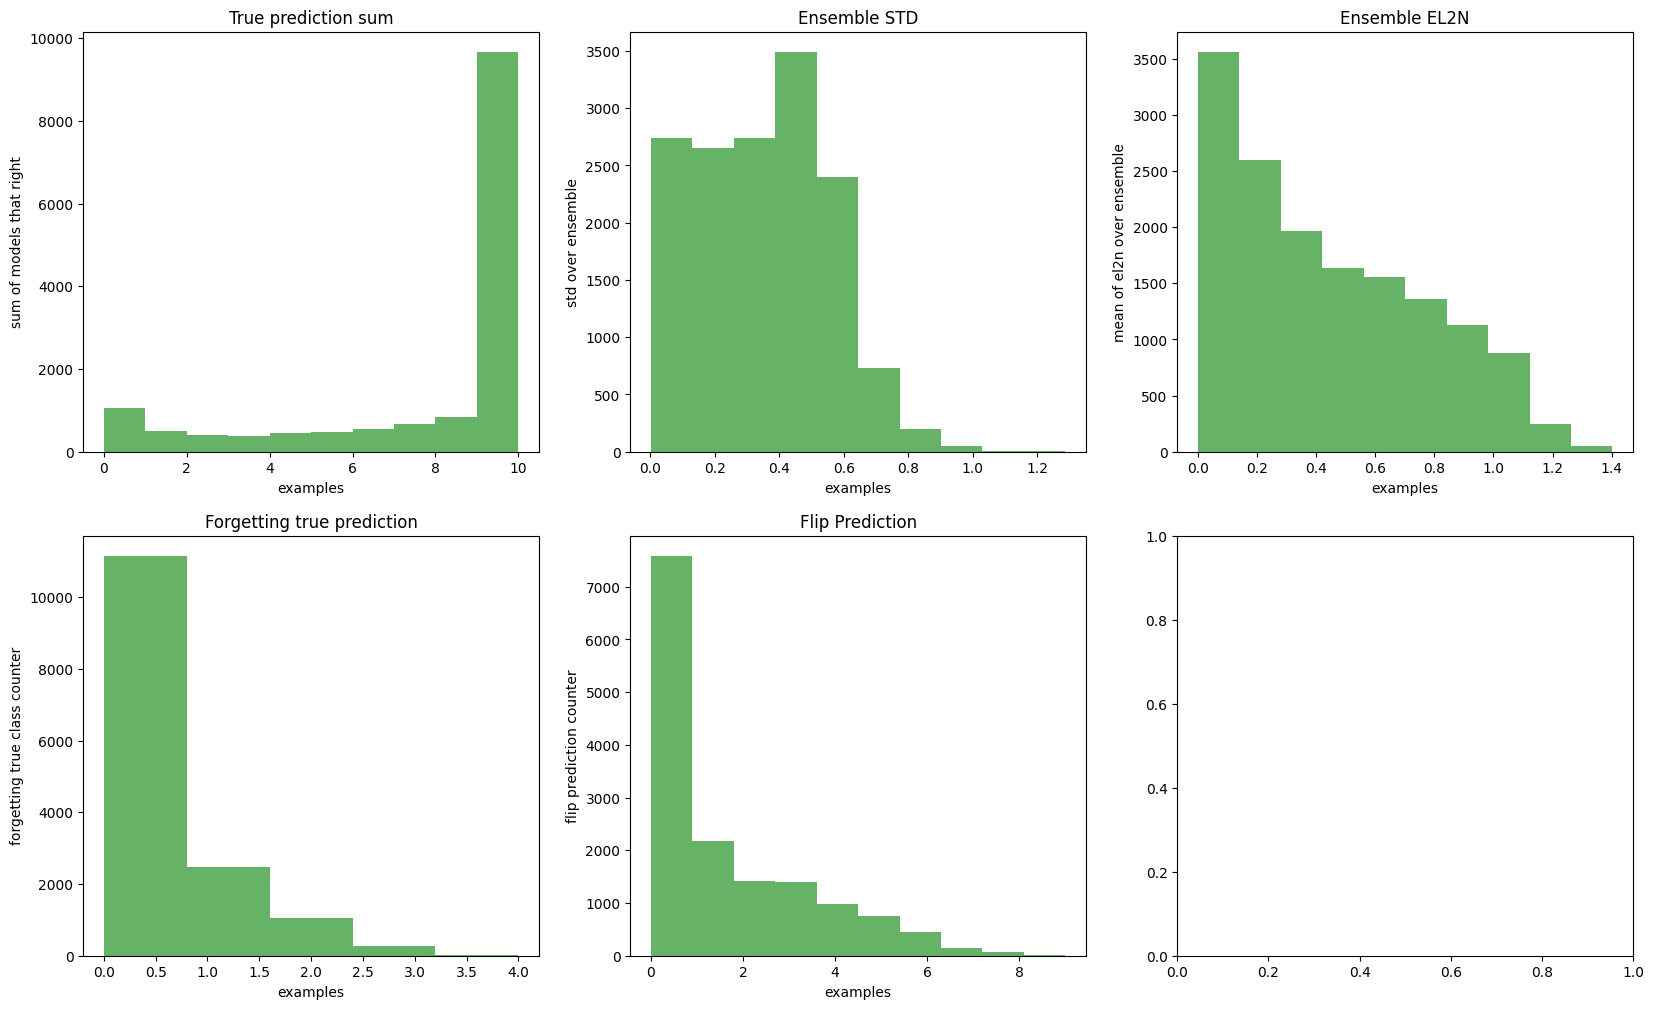

,EL2N,Std,True p sum,flip,forget
EL2N,1.000000,0.807607,-0.903157,0.534617,0.293298
Std,0.807607,1.000000,-0.630211,0.547764,0.317738
True p sum,-0.903157,-0.630211,1.000000,-0.435877,-0.181616
flip,0.534617,0.547764,-0.435877,1.000000,0.755434
forget,0.293298,0.317738,-0.181616,0.755434,1.000000


In [3]:
measures = torch.load(PATH_MEASURES)

pred_sum = measures['ensemble_pred_sum']
std = measures['ensemble_std'].sum(dim=1)
el2n = measures['el2n_scores']
forget = measures['forget']
flip = measures['flip']

idx_sorted_el2n = el2n.sort()[1].numpy()
idx_sorted_flip = flip.sort()[1].numpy()
idx_sorted_std = std.sort()[1].numpy()
idx_sorted_pred_sum = pred_sum.sort()[1].numpy()[::-1]
idx_true_forget = forget.sort()[1].numpy()
idx_random_prune = np.random.choice(np.arange(NUM_TRAIN), NUM_TRAIN, replace=False)

idx_sorted = {'random': idx_random_prune, 'el2n': idx_sorted_el2n, 'std': idx_sorted_std,
              'pred_sum': idx_sorted_pred_sum, 'flip': idx_sorted_flip, 'forget': idx_true_forget}

for ax, measure, title, y_label in zip(
        plt.subplots(2, 3, figsize=(20, 12))[1].reshape(-1),
        [pred_sum, std, el2n, forget, flip],
        ['True prediction sum', 'Ensemble STD', 'Ensemble EL2N', 'Forgetting true prediction', 'Flip Prediction'],
        ['sum of models that right', 'std over ensemble', 'mean of el2n over ensemble', 'forgetting true class counter',
         'flip prediction counter']):
    ax.set_ylabel(y_label)
    ax.set_xlabel('examples')
    ax.set_title(title)
    ax.hist(measure, bins=10 if title != 'Forgetting true prediction' else 5, facecolor='g', alpha=0.6)
plt.show()

data = pd.DataFrame({
    'EL2N': el2n.numpy(),
    'Std': std.numpy(),
    'True p sum': pred_sum.numpy(),
    'flip': flip.numpy(),
    'forget': forget.numpy()
})
data.corr()

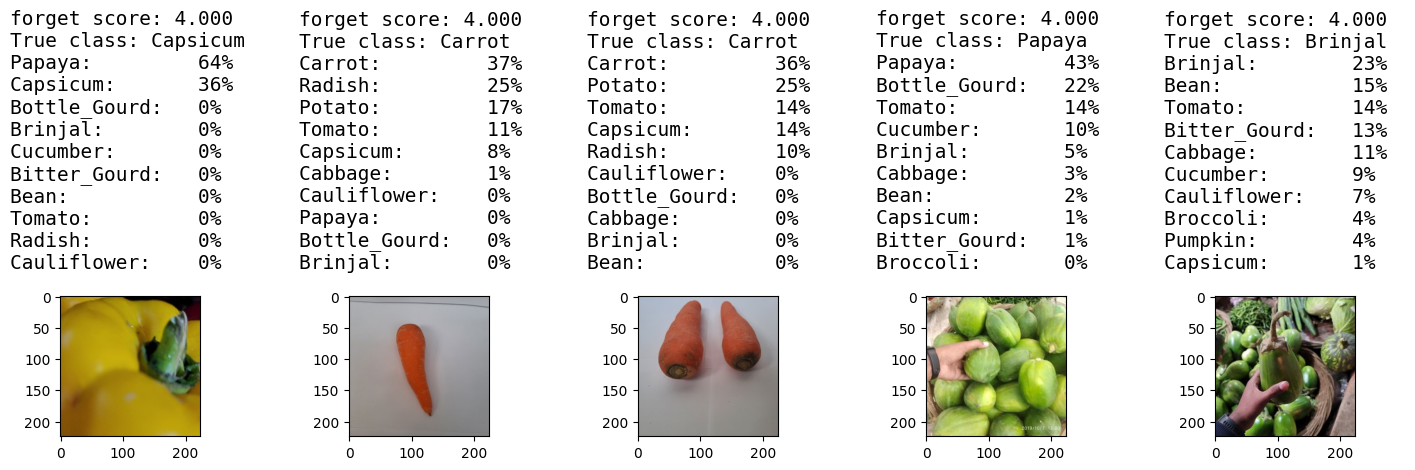

In [4]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.999, 1.), forget,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1),
                 score_name='forget')

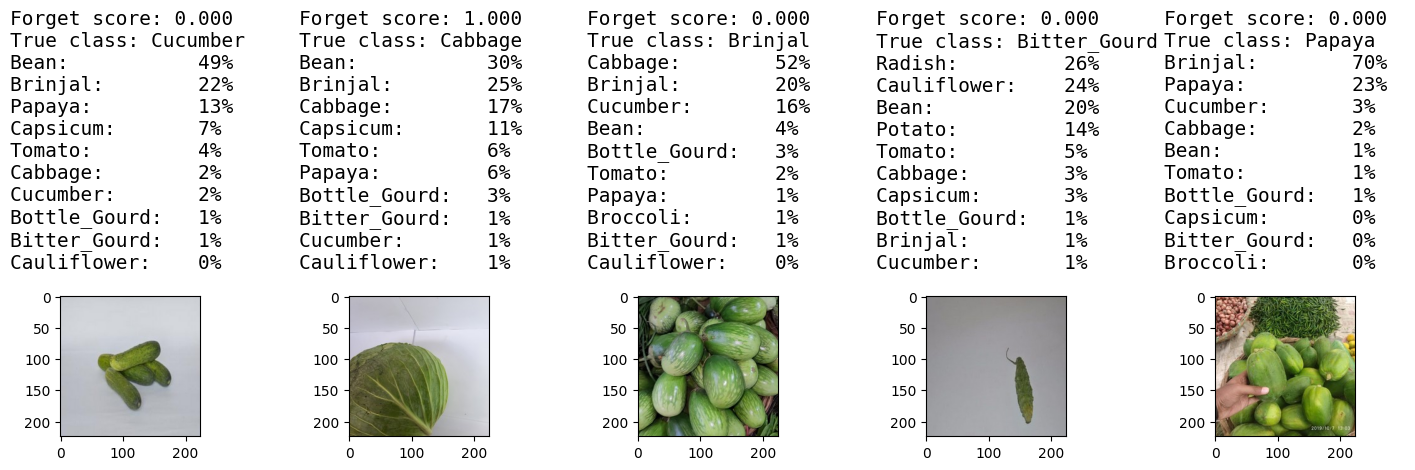

In [44]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.0, .1), pred_sum,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1), score_name='Forget')

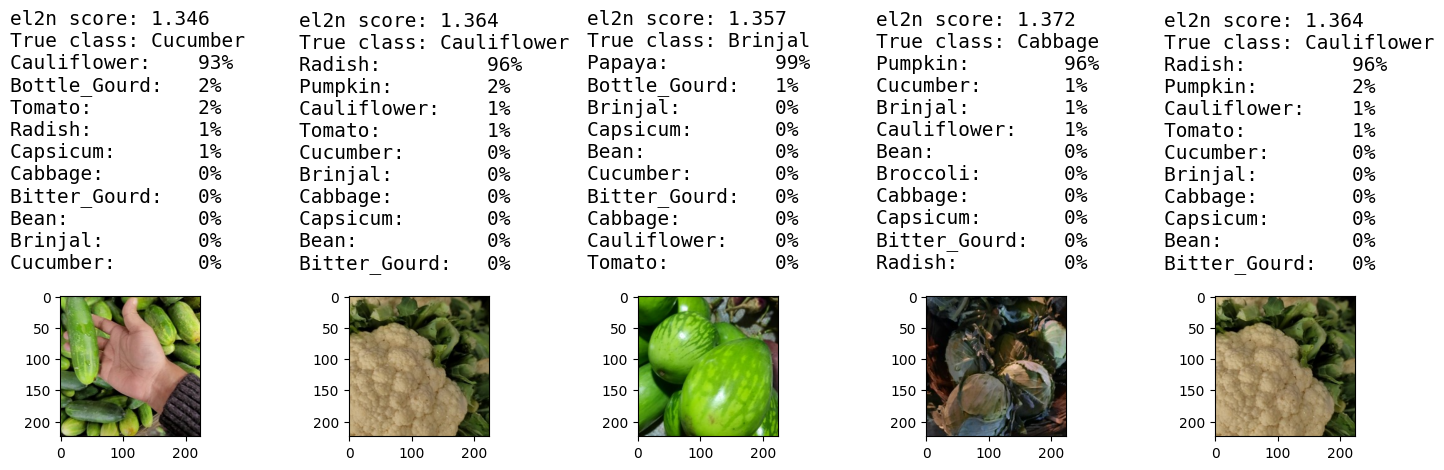

In [50]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.999, 1.), el2n,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1),
                 score_name='el2n')

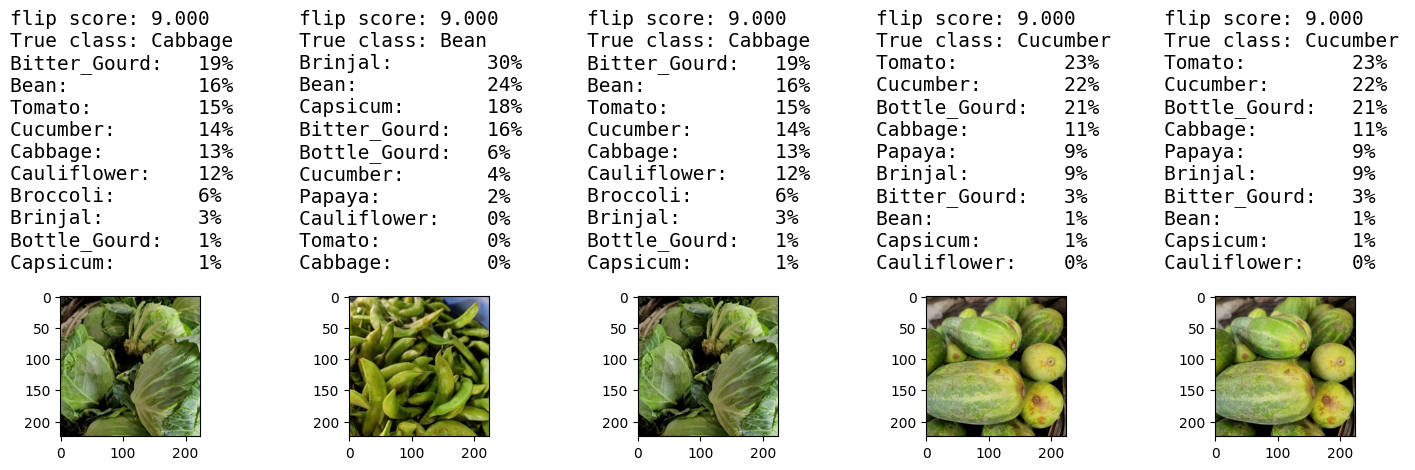

In [51]:
model_manager = ModelManager(NUM_CLASSES, model_name='flip_forget', dir_=NOTEBOOK_NAME, load=True, simple_model=True)
plot_img_and_top(dataset_train_raw, (.999, 1.), flip,
                 functional.softmax(model_manager.data_other['last_scores'], dim=1),
                 score_name='flip')

# Experiment 1.1
### train resnet18 on pruned dataset according to each measure, the prune is in range 10%-70% of the easiest examples

In [27]:
no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=False)
loader_train = get_loader(dataset_train, TRAIN_IDX, BATCH_SIZE, shuffle=True)
no_prune.train(loader_train, loader_test, loader_test, EPOCHS)

prune_sizes = [.1, .2, .3, .4, .5, .6, .7]
acc_test: dict[str:dict[float:float]] = {'no_prune': {p: no_prune.data['test']['acc'] for p in prune_sizes}}

print()
for name, idx in idx_sorted.items():
    acc_test[name] = {}
    for prune_size in prune_sizes:
        print(f'====     train model with {prune_size:.0%} prune according to {name} most hard     ======')
        num_train = int(NUM_TRAIN * (1. - prune_size))
        loader_train = get_loader(dataset_train, idx[-num_train:], BATCH_SIZE, shuffle=True)
        model_manager = ModelManager(NUM_CLASSES, model_name=f'exp1_{name}_{int(prune_size * 100)}p',
                                     dir_=NOTEBOOK_NAME,
                                     load=False, simple_model=False)
        model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

        acc_test[name][prune_size] = model_manager.data['test']['acc']
        print()


====     train model with 10% prune according to random most hard     ======

====     train model with 20% prune according to random most hard     ======

====     train model with 30% prune according to random most hard     ======

====     train model with 40% prune according to random most hard     ======

====     train model with 50% prune according to random most hard     ======

====     train model with 60% prune according to random most hard     ======

====     train model with 70% prune according to random most hard     ======

====     train model with 10% prune according to el2n most hard     ======

====     train model with 20% prune according to el2n most hard     ======

====     train model with 30% prune according to el2n most hard     ======

====     train model with 40% prune according to el2n most hard     ======

====     train model with 50% prune according to el2n most hard     ======

====     train model with 60% prune according to el2n most hard     =====

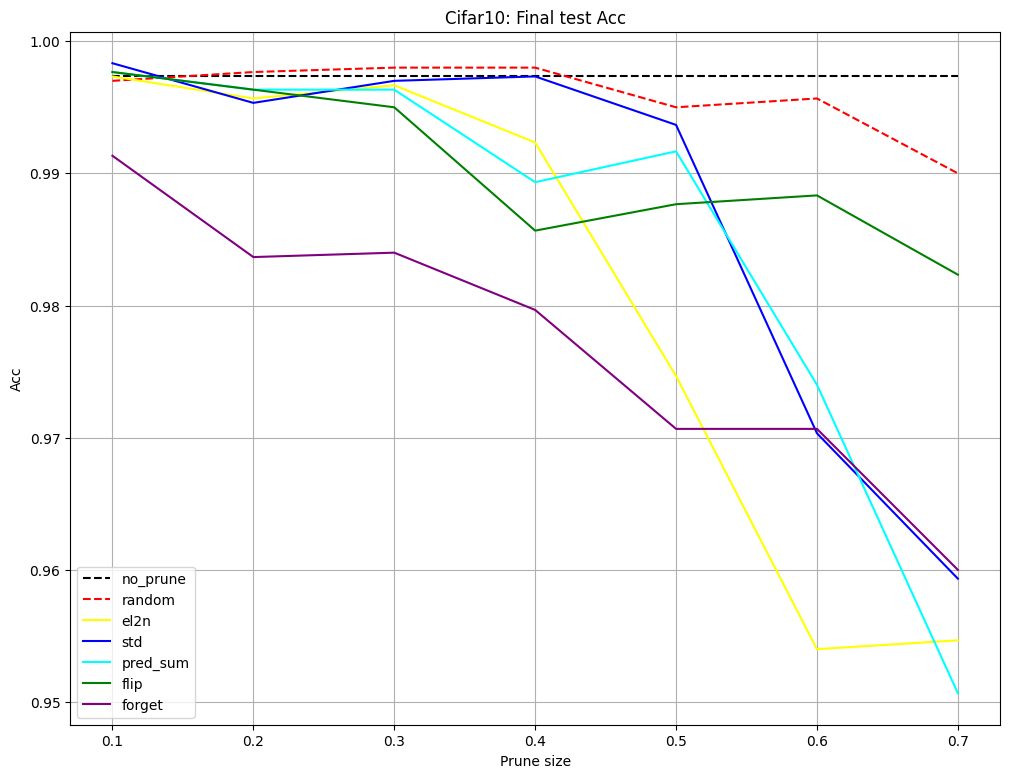

In [29]:
plt.figure(figsize=(12, 9))

markers = ('dashed', 'solid')
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple')
#          no       rand    el2n     std     sum     flip      forget
for i, prune_method in enumerate(acc_test):
    plt.plot(prune_sizes, [acc_test[prune_method][p] for p in prune_sizes], label=prune_method,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower left')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()

# Experiment 2.1
### train resnet18 on pruned dataset according to each measure, the prune is sliding window of 40% of examples from the easiest to hardest

In [16]:
exp2_prune = int(NUM_TRAIN * .4)
no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=True)
# loader_train = get_loader(dataset_train, TRAIN_IDX, BATCH_SIZE, True)
# no_prune.train(loader_train, loader_test, loader_test, EPOCHS)

# random
model_random = ModelManager(NUM_CLASSES, model_name='exp2_random', dir_=NOTEBOOK_NAME, load=False)
loader_train = get_loader(dataset_train, idx_random_prune[:exp2_prune], BATCH_SIZE, True)
model_random.train(loader_train, loader_test, loader_test, EPOCHS)

start_points = [.0, .1, .2, .3, .4, .5, .51, .52, .53, .54, .55, .56, .57, .58, .59, .6]
acc_test: dict[str:dict[float:float]] = {'no_prune': {p: no_prune.data['test']['acc'] for p in start_points},
                                         'random': {p: model_random.data['test']['acc'] for p in start_points}}

print()
for name, idx in idx_sorted.items():
    acc_test[name] = {}
    for start_point in start_points:
        start = round(NUM_TRAIN * start_point)
        print(f'====     train model from {start} to {start + exp2_prune} with {name} method    ======')
        loader_train = get_loader(dataset_train, idx[start:start + exp2_prune], BATCH_SIZE, True)
        model_manager = ModelManager(NUM_CLASSES, model_name=f'exp_2{name}_{int(start_point * 100)}',
                                     dir_=NOTEBOOK_NAME, load=False)
        model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

        acc_test[name][start_point] = model_manager.data['test']['acc']
        print()

Epoch: 0 Train: Loss: 0.030368 Acc: 0.760667  Validate Loss: 0.012347 Acc: 0.903333                                                         
Validation loss decreased (inf --> 0.012347).  Saving model to models_data/veg\no_prune
Epoch: 1 Train: Loss: 0.011982 Acc: 0.907467  Validate Loss: 0.014618 Acc: 0.887333                                                         
Epoch: 2 Train: Loss: 0.008477 Acc: 0.933067  Validate Loss: 0.008809 Acc: 0.925333                                                          
Validation loss decreased (0.012347 --> 0.008809).  Saving model to models_data/veg\no_prune
Epoch: 3 Train: Loss: 0.006014 Acc: 0.954800  Validate Loss: 0.005777 Acc: 0.948667                                                          
Validation loss decreased (0.008809 --> 0.005777).  Saving model to models_data/veg\no_prune
Epoch: 4 Train: Loss: 0.004999 Acc: 0.960867  Validate Loss: 0.002576 Acc: 0.979333                                                          
Validation loss de

In [17]:
acc_test

{'no_prune': {0.0: 0.9973333333333324,
  0.1: 0.9973333333333324,
  0.2: 0.9973333333333324,
  0.3: 0.9973333333333324,
  0.4: 0.9973333333333324,
  0.5: 0.9973333333333324,
  0.51: 0.9973333333333324,
  0.52: 0.9973333333333324,
  0.53: 0.9973333333333324,
  0.54: 0.9973333333333324,
  0.55: 0.9973333333333324,
  0.56: 0.9973333333333324,
  0.57: 0.9973333333333324,
  0.58: 0.9973333333333324,
  0.59: 0.9973333333333324,
  0.6: 0.9973333333333324},
 'random': {0.0: 0.9893333333333328,
  0.1: 0.9943333333333326,
  0.2: 0.991666666666666,
  0.3: 0.9933333333333326,
  0.4: 0.9916666666666659,
  0.5: 0.993999999999999,
  0.51: 0.9939999999999991,
  0.52: 0.9956666666666656,
  0.53: 0.9923333333333324,
  0.54: 0.9939999999999992,
  0.55: 0.9959999999999991,
  0.56: 0.9943333333333325,
  0.57: 0.9943333333333325,
  0.58: 0.9939999999999992,
  0.59: 0.9946666666666657,
  0.6: 0.9923333333333326},
 'el2n': {0.0: 0.8489999999999999,
  0.1: 0.8960000000000005,
  0.2: 0.9209999999999999,
  0.3: 

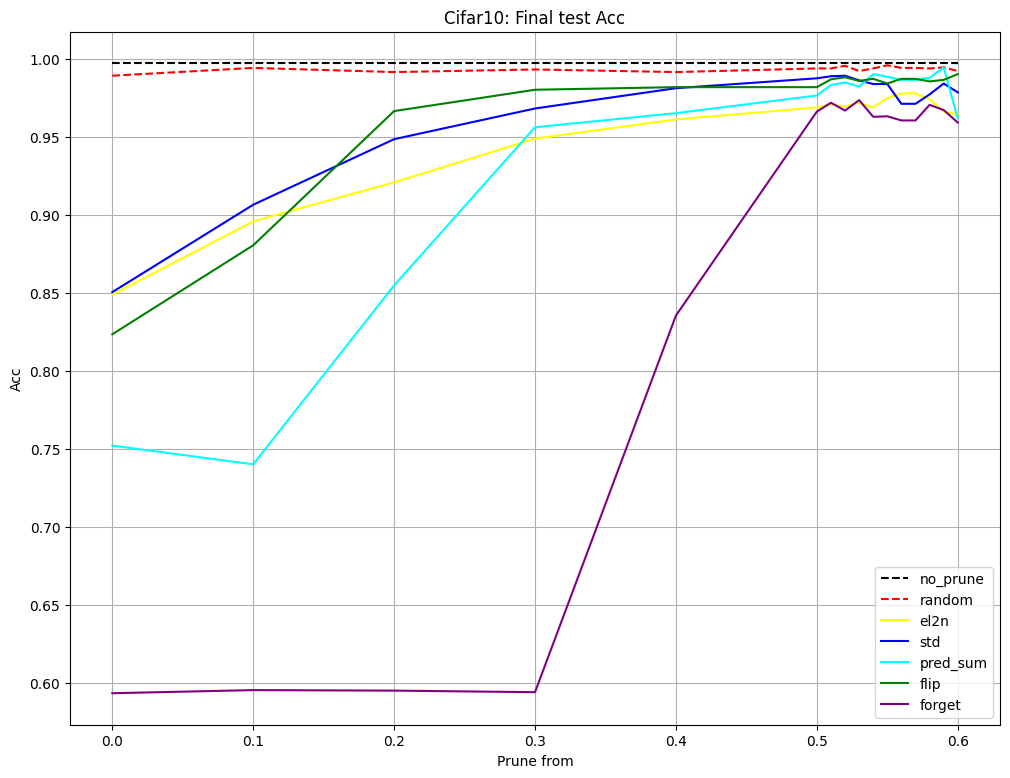

In [18]:
plt.figure(figsize=(12, 9))
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple')
#          no       rand    el2n     std     sum     flip      forget

markers = ('dashed', 'solid')
for i, prune_method in enumerate(acc_test):
    plt.plot(start_points, [acc_test[prune_method][p] for p in start_points], label=prune_method, c=colors[i],
             linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower right')
plt.grid(True)
plt.xlabel('Prune from')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()

# Experiment 1.2
### train resnet18 on pruned dataset according to each measure, the prune is in range 10%-90% of the hardest examples

In [20]:
no_prune = ModelManager(NUM_CLASSES, model_name='no_prune', dir_=NOTEBOOK_NAME, load=True)
# loader_train = get_loader(dataset_train, TRAIN_IDX, BATCH_SIZE, shuffle=True)
# no_prune.train(loader_train, loader_test, loader_test, EPOCHS)

prune_sizes = [.1, .2, .3, .4, .5, .6, .7, .8, .9]

acc_test_ex3: dict[str:dict[float:float]] = {'no_prune': {p: no_prune.data['test']['acc'] for p in prune_sizes}}

print()
for name, idx in idx_sorted.items():
    acc_test_ex3[name] = {}
    for prune_size in prune_sizes:
        print(f'====     train model with {prune_size:.0%} prune according to {name} most easy     ======')
        num_train = int(NUM_TRAIN * (1. - prune_size))
        loader_train = get_loader(dataset_train, idx[:num_train], BATCH_SIZE, shuffle=True)
        model_manager = ModelManager(NUM_CLASSES, model_name=f'exp3_{name}_{int(prune_size * 100)}p',
                                     dir_=NOTEBOOK_NAME,
                                     load=False, simple_model=False)
        model_manager.train(loader_train, loader_test, loader_test, EPOCHS)

        acc_test_ex3[name][prune_size] = model_manager.data['test']['acc']
        print()


====     train model with 10% prune according to random most easy     ======
Epoch: 0 Train: Loss: 0.032667 Acc: 0.745704  Validate Loss: 0.020620 Acc: 0.847667                                                         
Validation loss decreased (inf --> 0.020620).  Saving model to models_data/veg\exp3_random_10p
Epoch: 1 Train: Loss: 0.012323 Acc: 0.905111  Validate Loss: 0.010345 Acc: 0.914000                                                          
Validation loss decreased (0.020620 --> 0.010345).  Saving model to models_data/veg\exp3_random_10p
Epoch: 2 Train: Loss: 0.008754 Acc: 0.934815  Validate Loss: 0.020136 Acc: 0.842000                                                         
Epoch: 3 Train: Loss: 0.006863 Acc: 0.947630  Validate Loss: 0.009167 Acc: 0.927000                                                          
Validation loss decreased (0.010345 --> 0.009167).  Saving model to models_data/veg\exp3_random_10p
Epoch: 4 Train: Loss: 0.005620 Acc: 0.955926  Validate Loss: 

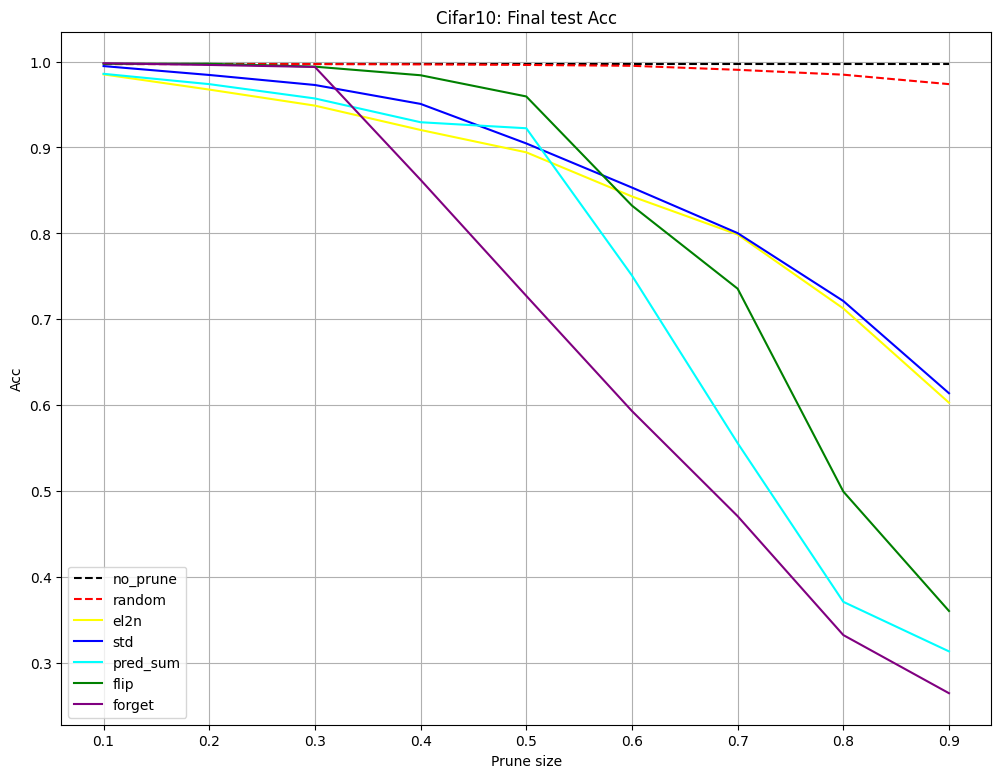

In [21]:
plt.figure(figsize=(12, 9))

markers = ('dashed', 'solid')
colors = ('black', 'red', 'yellow', 'blue', 'cyan', 'green', 'purple')
#          no       rand    el2n     std     sum     flip      forget
for i, prune_method in enumerate(acc_test_ex3):
    plt.plot(prune_sizes, [acc_test_ex3[prune_method][p] for p in prune_sizes], label=prune_method,
             c=colors[i], linestyle=markers[0] if i < 2 else markers[1])
plt.legend(loc='lower left')
plt.grid(True)
plt.xlabel('Prune size')
plt.ylabel('Acc')
plt.title('Cifar10: Final test Acc')
plt.show()